# Crypto Market Prediction — Feature Engineering & Modeling

This notebook focuses on transforming raw signals and engineered indicators into predictive features, training a model on them, and evaluating performance based on the competition’s target metric: **Pearson correlation** between predictions and true labels.

---

**Pipeline Structure:**
1. Load pre-processed data
2. Feature engineering
3. Train/validation split (time-aware)
4. Model training (baseline → optimized)
5. Evaluation: Pearson correlation


In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings("ignore")

## Load EDA-ready Data

In [190]:
train = pd.read_parquet("data/train.parquet", engine="pyarrow")
train.index = pd.to_datetime(train.index)
train = train.sort_index()
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X772,X773,X774,X775,X776,X777,X778,X779,X780,label
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.181844,-0.637860,0.006652,0.136870,0.116698,...,0.333753,-0.009992,-0.695595,-0.444077,-0.191238,-0.184251,-0.471897,-0.625428,-0.553991,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.489497,-0.075619,0.431594,0.522400,0.475255,...,0.333657,-0.010040,-0.696226,-0.452866,-0.200082,-0.188929,-0.472842,-0.625832,-0.554426,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.260121,-0.444684,0.100695,0.224729,0.203282,...,0.333667,-0.010037,-0.696832,-0.461383,-0.208786,-0.193571,-0.473785,-0.626236,-0.554860,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.099976,-0.666728,-0.123858,0.019197,0.014459,...,0.333174,-0.010279,-0.697391,-0.469628,-0.217350,-0.198175,-0.474726,-0.626639,-0.555294,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.270893,-0.325973,0.116336,0.234311,0.214073,...,0.333171,-0.010283,-0.697940,-0.477622,-0.225780,-0.202745,-0.475666,-0.627043,-0.555728,0.362452


In [191]:
print(train.isna().sum().sort_values(ascending=False).head(10))

label      0
bid_qty    0
X765       0
X764       0
X763       0
X762       0
X761       0
X760       0
X759       0
X758       0
dtype: int64


## Feature Engineering

In [192]:
train['buy_pressure'] = train['buy_qty'] / (train['buy_qty'] + train['sell_qty'] + 1e-5)
train['bid_ask_ratio'] = train['bid_qty'] / (train['bid_qty'] + train['ask_qty'] + 1e-5)

train['volume_rolling_mean_10'] = train['volume'].shift(1).rolling(10).mean()
train['buy_pressure_rolling_std_10'] = train['buy_pressure'].shift(1).rolling(10).std()
train['rolling_mean_5'] = train['volume'].shift(1).rolling(5).mean()

train['log_volume'] = np.log1p(train['volume'])
train['delta_bid_ask'] = train['bid_qty'] - train['ask_qty']
train['order_imbalance'] = (train['bid_qty'] - train['ask_qty']) / (train['bid_qty'] + train['ask_qty'] + 1e-5)
train['volatility_5'] = train['volume'].shift(1).rolling(5).std()

train['buy_pressure_x_bidask'] = train['buy_pressure'] * train['bid_ask_ratio']
train['volume_to_volatility'] = train['volume'] / (train['volatility_5'] + 1e-5)

# train['label_lag1'] = train['label'].shift(1)
# train['return_lag1'] = train['label_lag1'] - train['label_lag1'].shift(1)

In [193]:
train.dropna(inplace=True)

## Train/Validation Split (Time-based)

In [194]:
X = train.drop(columns=['label'])
y = train['label']

In [195]:
cutoff_idx = int(len(train) * 0.9)
X_train, X_val = X.iloc[:cutoff_idx], X.iloc[cutoff_idx:]
y_train, y_val = y.iloc[:cutoff_idx], y.iloc[cutoff_idx:]

In [196]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)

Train: (473288, 796)
Validation: (52588, 796)


In [197]:
print([col for col in X_train.columns if 'label' in col])

[]


## Model Training — CatBoost Regressor

In [198]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=8,
    loss_function='MAE',         
    eval_metric='MAE',           
    early_stopping_rounds=200,   
    verbose=100,
    random_seed=42,
    task_type='CPU'
)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

0:	learn: 0.6301304	test: 0.7130530	best: 0.7130530 (0)	total: 559ms	remaining: 18m 36s
100:	learn: 0.6064581	test: 0.7086437	best: 0.7085573 (92)	total: 50.2s	remaining: 15m 43s
200:	learn: 0.5872115	test: 0.7094346	best: 0.7085529 (105)	total: 1m 37s	remaining: 14m 30s
300:	learn: 0.5724393	test: 0.7102251	best: 0.7085529 (105)	total: 2m 18s	remaining: 13m 2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7085529341
bestIteration = 105

Shrink model to first 106 iterations.


## Validation Performance

In [199]:
val_preds = model.predict(X_val)

corr, _ = pearsonr(val_preds, y_val)
print(f"Validation Pearson Correlation: {corr:.5f}")

Validation Pearson Correlation: 0.10885


In [ ]:
# def evaluate_custom_model(train_df, feature_list, model_params, label_col='label', test_size=0.1, random_state=42):
#     from catboost import CatBoostRegressor
#     from sklearn.model_selection import train_test_split
#     from scipy.stats import pearsonr
#     import time

#     
#     df = train_df[feature_list + [label_col]].dropna()
#     X = df[feature_list]
#     y = df[label_col]

#     # Time-based split
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

#     
#     model = CatBoostRegressor(**model_params)

#     
#     start = time.time()
#     model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
#     duration = time.time() - start

#     
#     val_preds = model.predict(X_val)
#     corr, _ = pearsonr(val_preds, y_val)

#     
#     print("=" * 60)
#     print(f"Features: {feature_list}")
#     print(f"Pearson Correlation: {corr:.5f}")
#     print(f"⏱Training time: {duration:.2f} sec")
#     print(f"Best iteration: {model.get_best_iteration()}")
#     print("=" * 60)

#     return corr, duration, model.get_best_iteration()

In [201]:
# feature_list = [
#     'buy_pressure',
#     'bid_ask_ratio',
#     'volume_rolling_mean_10',
#     'buy_pressure_rolling_std_10',
#     'rolling_mean_5',
#     'log_volume',
#     'delta_bid_ask',
#     'order_imbalance',
#     'volatility_5',
#     'buy_pressure_x_bidask',
#     'volume_to_volatility'
# ]

In [202]:
# model_params = {
#     'iterations': 2000,
#     'learning_rate': 0.01,
#     'depth': 8,
#     #'grow_policy': 'Lossguide',
#     #'min_data_in_leaf': 5,
#     'loss_function': 'MAE',
#     'eval_metric': 'MAE',
#     'early_stopping_rounds': 200,
#     #'l2_leaf_reg': 3,
#     'random_seed': 42,
#     'verbose': 100,
#     'task_type': 'CPU'
# }

In [203]:
# evaluate_custom_model(train, feature_list, model_params)

## Another model

In [204]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)
preds = ridge.predict(X_val)
print("Ridge Pearson:", np.corrcoef(preds, y_val)[0, 1])

Ridge Pearson: 0.08240077870100909


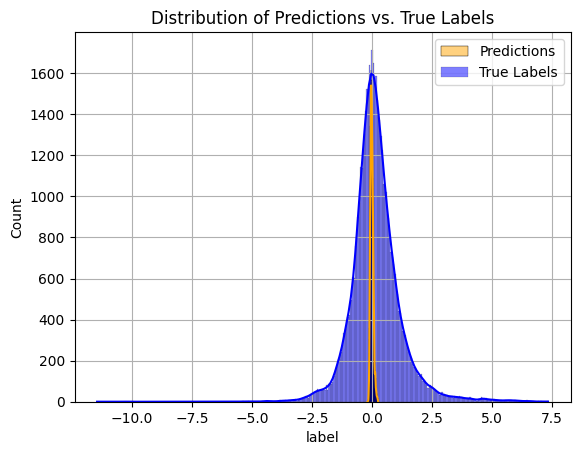

In [205]:
sns.histplot(val_preds, kde=True, color='orange', label='Predictions')
sns.histplot(y_val, kde=True, color='blue', label='True Labels')
plt.legend()
plt.title("Distribution of Predictions vs. True Labels")
plt.grid(True)
plt.show()

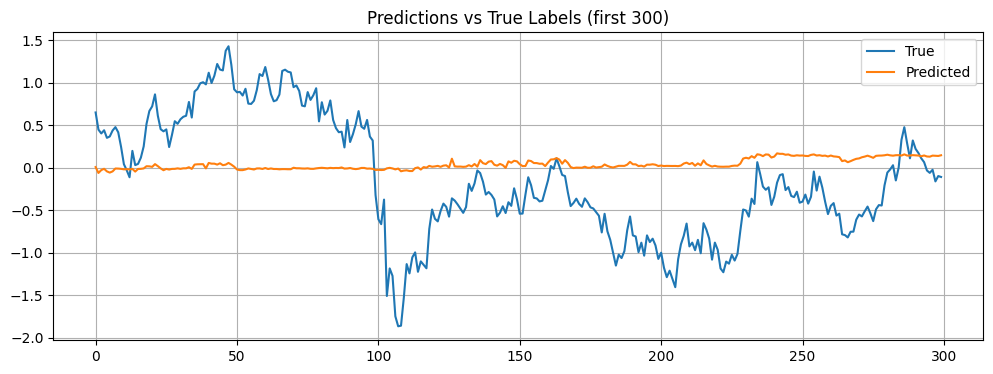

In [207]:
import matplotlib.pyplot as plt

val_preds = model.predict(X_val)

plt.figure(figsize=(12, 4))
plt.plot(y_val.values[:300], label='True')
plt.plot(val_preds[:300], label='Predicted')
plt.legend()
plt.grid(True)
plt.title("Predictions vs True Labels (first 300)")
plt.show()

### Feature Importance

In [208]:
importances = model.get_feature_importance(prettified=True)
importances.head(20)

,Feature Id,Importances
0,X759,4.158664
1,X758,4.048786
2,X283,4.029887
3,X751,3.886411
4,X285,3.328378
5,X21,3.161125
6,X752,2.981604
7,X624,2.824306
8,X613,2.660639
9,X592,2.497504


### Save the Model

In [209]:
model.save_model("catboost_crypto_model.cbm")

## Summary

### Key Takeaways:

- Built initial signals like `buy_pressure`, `bid_ask_ratio`, and rolling features.
- Applied time-based validation split to simulate real-world scenario.
- CatBoost baseline achieved a Pearson correlation of ~0.10885.
- Next step: test inference and submission file in the final notebook.